# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [11]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## Recurrent Models

Darts includes two recurrent forecasting model classes: `RNNModel` and `BlockRNNModel`. 

`RNNModel` is fully recurrent in the sense that, at prediction time, an output is computed using these inputs:

- the previous target value, which will be set to the last known target value for the first prediction,
  and for all other predictions it will be set to the previous prediction
- the previous hidden state
- the current covariates (if the model was trained with covariates)

A prediction with forecasting horizon `n` thus is created in `n` iterations of `RNNModel` predictions and requires `n` future covariates to be known. This model is suited for forecasting problems where the target series is highly dependent on covariates that are known in advance.

`BlockRNNModel` has a recurrent encoder stage, which encodes its input, and a fully-connected neural network decoder stage, which produces a prediction of length `output_chunk_length` based on the last hidden state of the encoder stage. Consequently, this model produces 'blocks' of forecasts and is restricted to looking at covariates with the same time index as the input target series.

## Air Passenger Example
This is a data set that is highly dependent on covariates. Knowing the month tells us a lot about the seasonal component, whereas the year determines the effect of the trend component. Both of these covariates are known in the future, and thus the `RNNModel` class is the preferred choice for this problem.

In [14]:
# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
training_cutoff = pd.Timestamp('19571201')
# training_cutoff = pd.Timestamp('19590101')
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
covariates = datetime_attribute_timeseries(series, attribute='year', one_hot=False)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute='month', one_hot=False))
covariates = covariates.stack(TimeSeries.from_times_and_values(times=series.time_index, values=np.arange(len(series))))

cov_train, cov_val = covariates.split_after(training_cutoff)

scaler_covs = Scaler()
cov_train_transformed = scaler_covs.fit_transform(cov_train)
cov_val_transformed = scaler_covs.transform(cov_val)

covariates_transformed = cov_train_transformed.append(cov_val_transformed)

# # WORKS BEST
# default quantiles for QuantileRegression
quantiles = [
    0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99
]
input_chunk_length = 24
forecast_horizon = 6
my_model = TFTModel(
    # optimizer_kwargs={'lr': 1e-3},
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4,
    full_attention=False,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    # add_cyclic_encoder='month',
    # add_relative_time_index=True,
    random_state=42,
    likelihood=QuantileRegression(quantiles=quantiles),
    model_name='Air_TFT',
    force_reset=True,
    save_checkpoints=True,
    log_tensorboard=False,
)

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In what follows, we can just provide the whole `covariates` series as `future_covariates` argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [15]:
my_model.fit(train_transformed,
             future_covariates=covariates_transformed,
             val_series=val_transformed,
             val_future_covariates=covariates_transformed,
             verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

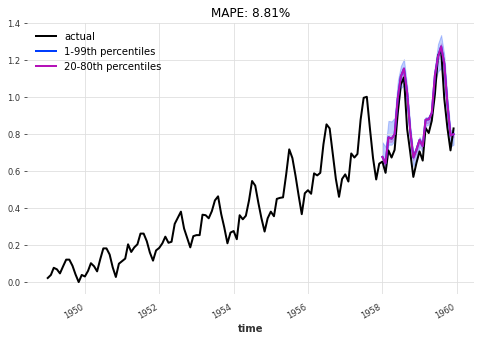

In [16]:
def eval_model(model):
    pred_series = model.predict(n=24, num_samples=1000)
    
    plt.figure(figsize=(8,5))
    
    # plot actual series
    series_transformed[:pred_series.end_time()].plot(label='actual')

    # plot prediction with quantile ranges
    pred_series.plot(low_quantile=0.01, high_quantile=0.99, label='1-99th percentiles')
    pred_series.plot(low_quantile=0.2, high_quantile=0.8, label='20-80th percentiles')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
eval_model(my_model)


### Backtesting
Let's backtest our `RNN` model, to see how it performs at a forecast horizon of 6 months:

In [17]:
backtest_series = my_model.historical_forecasts(series_transformed,
                                                future_covariates=covariates_transformed,
                                                start=train.end_time() + train.freq,
                                                num_samples=1000,
                                                forecast_horizon=forecast_horizon,
                                                stride=forecast_horizon,
                                                last_points_only=False,
                                                retrain=False,
                                                verbose=True)

  0%|          | 0/6 [00:00<?, ?it/s]

MAPE: 7.31%


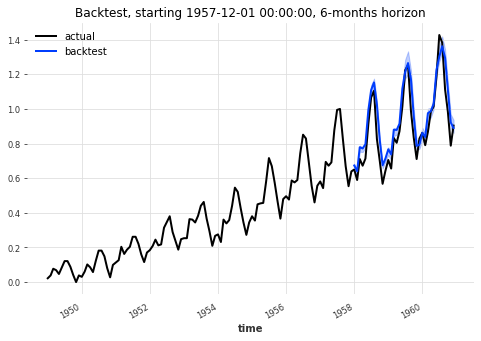

In [18]:
backtest_series = concatenate(backtest_series)
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title(f'Backtest, starting {training_cutoff}, {forecast_horizon}-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))